# Analyzing a Discrete Heart Rate Signal Using Python – Part 2

## Calculating Frequency Domain Measures
First we create an evenly spaced timeline for the R-R intervals. To do this we take the sample position of all R-peaks, which is housed in the list dict[‘peaklist’] that we calculated in part 1. We then assign the y-values to these sample positions from the list dict[‘RR_list’], which contains the duration of all R-R intervals. Finally we interpolate the signal.

Source: http://www.paulvangent.com/2016/03/21/analyzing-a-discrete-heart-rate-signal-using-python-part-2/ 

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.interpolate import interp1d #Import the interpolate function from SciPy

peaklist = [63,
 165,
 264,
 360,
 460,
 565,
 674,
 773,
 863,
 953,
 1048,
 1156,
 1272,
 1385,
 1487,
 1592,
 1698,
 1803,
 1897,
 1994,
 2097,
 2206,
 2308,
 2406]

RR_list = [1020.0,
 990.0,
 960.0,
 1000.0,
 1050.0,
 1090.0,
 990.0,
 900.0,
 900.0,
 950.0,
 1080.0,
 1160.0,
 1130.0,
 1020.0,
 1050.0,
 1060.0,
 1050.0,
 940.0,
 970.0,
 1030.0,
 1090.0,
 1020.0,
 980.0]
RR_x = peaklist[1:] #Remove the first entry, because first interval is assigned to the second beat.
RR_y = RR_list #Y-values are equal to interval lengths


In [25]:
#Create evenly spaced timeline starting at the second peak, its endpoint and length equal to position of last peak
RR_x_new = np.linspace(RR_x[0],RR_x[-1],RR_x[-1]) 


In [26]:
f = interp1d(RR_x, RR_y, kind='cubic') #Interpolate the signal with cubic spline interpolation

Note that the time series does not start at the first peak, but at the sample position of the second R-peak. Because we work with the intervals, the first interval is available at the second peak.
We can now use the created function f() to find the y value of any x-position within our signal range:

In [30]:
print( f(250))
#Returns 997.619845418, the Y value at x=250

996.9413687714588


Simlarly, we can pass our entire timeseries RR_x_new to the function and plot it:

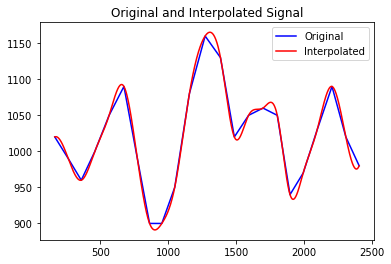

In [37]:
plt.title("Original and Interpolated Signal")
plt.plot(RR_x, RR_y, label="Original", color='blue')
plt.plot(RR_x_new, f(RR_x_new), label="Interpolated", color='red')
plt.legend()
plt.show()

Now to find the frequencies that make up the interpolated signal, use numpy’s fast fourier transform np.fft.fft() method, calculate sample spacing, convert sample bins to Hz and plot:

In [63]:
dataset = pd.read_csv("data.csv")

#Calculate moving average with 0.75s in both directions, then append do dataset
hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 100 #The example dataset was recorded at 100Hz
#Set variables
n = len(dataset.hart) #Length of the signal
n


2483

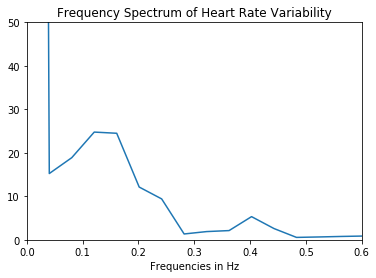

In [64]:
frq = np.fft.fftfreq(len(dataset.hart), d=((1/fs))) #divide the bins into frequency categories
frq = frq[range(int(n/2))] #Get single side of the frequency range

#Do FFT
Y = np.fft.fft(f(RR_x_new))/n #Calculate FFT
Y = Y[range(int(n/2))] #Return one side of the FFT

#Plot
plt.title("Frequency Spectrum of Heart Rate Variability")
plt.xlim(0,0.6) #Limit X axis to frequencies of interest (0-0.6Hz for visibility, we are interested in 0.04-0.5)
plt.ylim(0, 50) #Limit Y axis for visibility
plt.plot(frq, abs(Y)) #Plot it
plt.xlabel("Frequencies in Hz")
plt.show()

Nice! You can clearly see the LF and HF frequency peaks in the signal.
The last thing remaining is to integrate the area under curve at the LF (0.04 – 0.15Hz) and HF (0.16 – 0.5Hz) frequency bands. We need to find the data points corresponding to the frequency range we’re interested in. During the FFT we calculated the one-sided frequency range frq, so we can search this for the required data point positions.

In [65]:
lf = np.trapz(abs(Y[(frq>=0.04) & (frq<=0.15)])) #Slice frequency spectrum where x is between 0.04 and 0.15Hz (LF), and use NumPy's trapezoidal integration function to find the area
print("LF:", lf)

hf = np.trapz(abs(Y[(frq>=0.16) & (frq<=0.5)])) #Do the same for 0.16-0.5Hz (HF)
print("HF:", hf)

LF: 38.88976360240564
HF: 47.317782223388704


These are the areas under the frequency plot at the frequency spectra of interest. Remember from the theory that HF is related to breathing and LF to short-term blood pressure regulation. The measures have also been implicated in increased mental activity.